In [1]:
import math
from numpy import linalg as LA
import numpy as np
from matplotlib import pyplot as plt 

import random
import os
from numba import njit, prange, cuda
import itertools
import sympy as sp

def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)

def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res

def gen_jw(w):
    return lams1 * gams1**2 / (((w - mu_x) - omgs)**2 + gams1**2)


def gen_jw_sp(w, omgs1):
    return lams1 * gams1**2 / (((w - mu_x) - omgs1)**2 + gams1**2)

def prony(n = 2500, n_gamma = 11, scale = 100, scale_fft = 500, n_fft = 100000, filter_ = 0.0001, sigma = 1, omgs1 = 0):
    
    if sigma == 1:
        omgs1 = omgs1 * -1
    
    print(sigma, omgs1)
    
    n_rate = (scale_fft * scale/ (4 * n))
    print(n_rate)
    n_rate = int(n_rate)
    w = np.linspace(0, scale_fft * np.pi, n_fft + 3)[:-1]
    dw = w[1] - w[0]

    jw = gen_jw_sp(w,omgs1)
    cw1 = jw / (1 + np.exp(- sigma * beta * (w - mu_x)))
    cw2 = jw / (1 + np.exp(sigma * beta * (w - mu_x)))
    # del jw

    cw1[0] = cw1[0] / 2
    cw2[0] = cw2[0] / 2
    if sigma == -1:
        fft_ct = (np.fft.ifft(cw1) * len(cw1) * dw + np.fft.fft(cw2) * dw) / np.pi
    if sigma == 1:
        fft_ct = (np.fft.fft(cw1) * dw + np.fft.ifft(cw2) * len(cw2) * dw) / np.pi
    fft_t = 2 * np.pi * np.fft.fftfreq(len(cw1), dw)
    del cw1, cw2

    print(max(fft_t))
    fft_ct = fft_ct[(scale>=fft_t) & (fft_t >= 0)][::n_rate]
    fft_t = fft_t[(scale>=fft_t) & (fft_t >= 0)][::n_rate]
    t = fft_t
    res_t = np.zeros(len(t), dtype=complex)
    
    n_sample = n + 1
    h = np.imag(fft_ct)
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    # del H
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    #print(vs[:100])
    #vs = vs[:20]
    #Qp = Qp[:, :20]

    gamma = np.roots(Qp[:, n_gamma][::-1])
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_imag = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_imag = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))

    res_t = np.zeros(len(t), dtype=complex)
    fit_t(fft_t, res_t, -t_imag / scale, omega_imag)
    plt.plot(fft_t, np.imag(fft_ct) - res_t)
    #plt.savefig("imag_{}.pdf".format(n_gamma))
    plt.show()

    h = np.real(fft_ct)
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    # del H
    phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    #print(vs[:100])
    #vs = vs[:20]
    #Qp = Qp[:, :20]

    gamma = np.roots(Qp[:, n_gamma][::-1])
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_real = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_real = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))

    res_t = np.zeros(len(t), dtype=complex)
    fit_t(fft_t, res_t, -t_real / scale, omega_real)
    plt.plot(fft_t, np.real(fft_ct) - res_t)
    #plt.savefig("real_{}.pdf".format(n_gamma))
    plt.show()
    
    etal1 = np.append(1.j * omega_imag, omega_real)
    expn1 = np.append(-t_imag / scale, -t_real / scale)

    expn1 = expn1[np.abs(etal1) > filter_]
    etal1 = etal1[np.abs(etal1) > filter_]
    
    return etal1, expn1
    


<ipython-input-2-360023925b83>:21: RuntimeWarning: overflow encountered in exp
  plt.scatter(w, 1/(1 + np.exp(sigma * beta * (w - mu_x))),s=4)
<ipython-input-2-360023925b83>:22: RuntimeWarning: overflow encountered in exp
  plt.plot(w, jw / (1 + np.exp(sigma * beta * (w - mu_x))), label='jw*fermi')


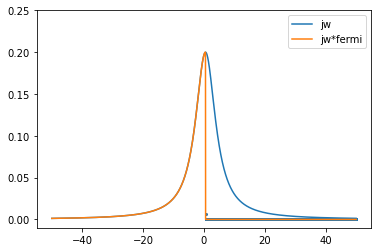

In [2]:
lams1 = 0.2
gams1 = 4.0
omgs = 0.0
temp = 0.001
beta = int(1 / temp)
mu_x = 0.5
sigma = 1

# n = 2500         # dimension of Hankel matrix
num_prony = 10  # number of real or imagnary prony poles
# scale = 500
# scale_fft = 100
# n_fft = 10000000

len_ = 10000
spe_wid = 50
w = np.linspace(-spe_wid, spe_wid, len_)

jw = gen_jw(w)
plt.plot(w, jw, label='jw')
plt.scatter(w, 1/(1 + np.exp(sigma * beta * (w - mu_x))),s=4)
plt.plot(w, jw / (1 + np.exp(sigma * beta * (w - mu_x))), label='jw*fermi')
plt.ylim(-0.01,0.25)
plt.legend(loc=1)
plt.show()

<ipython-input-1-66f270296ec6>:42: RuntimeWarning: overflow encountered in exp
  cw1 = jw / (1 + np.exp(- sigma * beta * (w - mu_x)))


0.0
-1 0.0
5.0
200.0


/home/ZDC/program/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


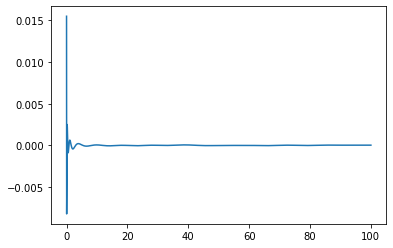

/home/ZDC/program/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


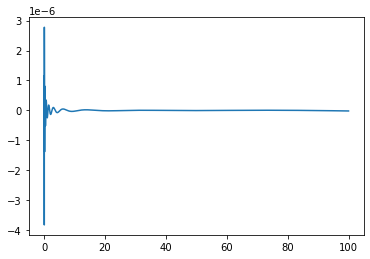

In [3]:
print(omgs)

etal1, expn1 = prony(n_gamma = num_prony, sigma = -1, omgs1 = omgs)

<ipython-input-4-6a6479261d81>:4: RuntimeWarning: overflow encountered in exp
  phixx = gen_jw(w) / (1 + np.exp(sigma * beta * (w - mu_x)))


0.0


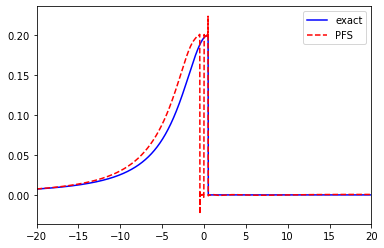

In [4]:
len_ = 1000000
spe_wid = 20
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = gen_jw(w) / (1 + np.exp(sigma * beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J1, expn1, etal1, sigma)

print(omgs)

plt.plot(w, (phixx.real), "b", label="exact")
plt.plot(w, (res_J1.real), "r--", label="PFS")
plt.xlim(-20, 20)
plt.legend(loc=1)
plt.show()